## **Importing Packages**

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras import layers, optimizers
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


import matplotlib.pyplot as plt
from PIL import Image 
from glob import glob
import tensorflow as tf

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler , StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

In [11]:
label = []
for f in fname:
    category = f.split('.')
    if category[2] != 'jpg':
      print(category[2])
    if category[0] == "cat":
        label.append(0)
    else:
        label.append(1)

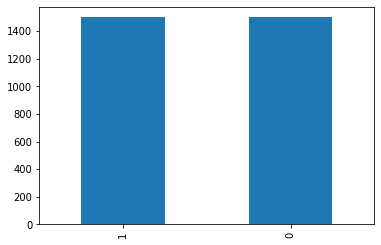

In [12]:
df = pd.DataFrame({ 'filename': fname, 'label': label })
df['label'].value_counts().plot.bar()

In [13]:
print(df.shape)

(3002, 2)


## **Split train and validation set**

In [14]:
train_df, val_df = train_test_split(df, test_size=0.3)
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [15]:
train_df = train_df.drop(['index'], axis = 1)
val_df = val_df.drop(['index'], axis = 1)
print(train_df.shape, val_df.shape)

(2401, 2) (601, 2)


In [ ]:
train_df['label'] = train_df['label'].astype('str')
val_df['label'] = val_df['label'].astype('str')


## **Data Augmentation**

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=True,  
        featurewise_std_normalization=True,  
        samplewise_std_normalization=True,  
        zca_whitening=False,  
        rotation_range=0.7,  
        zoom_range = 0.2, 
        width_shift_range=0.30,  
        height_shift_range=0.25,  
        horizontal_flip=False,  
        vertical_flip=True, 
        rescale=1./255, 
)  

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


## **Training Generator**

In [18]:
train_generator = datagen.flow_from_dataframe(
                dataframe = train_df, 
                directory = "dogs-vs-cats/train/", 
                x_col = "filename", 
                y_col = "label", 
                batch_size = 256, 
                seed = 1, 
                shuffle = True, 
                class_mode = "binary", 
                target_size=(256, 256) 
) 

Found 2401 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


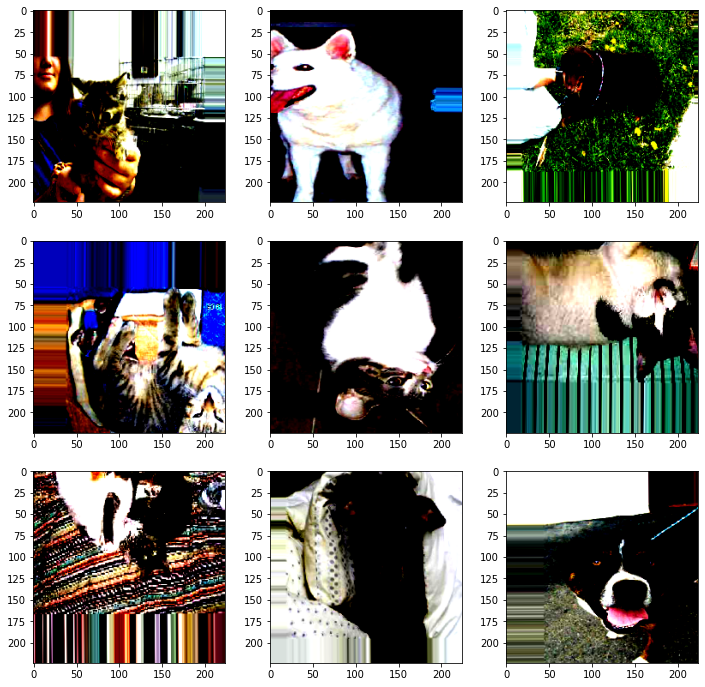

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_img, Y_img in train_generator:
        image = X_img[0]
        plt.imshow(image)
        break
plt.show()

## **Validation Generator**

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
                dataframe = val_df, 
                directory = "dogs-vs-cats/train/", 
                x_col = "filename", 
                y_col = "label", 
                batch_size = 256, 
                class_mode = 'binary', 
                target_size = (256, 256), 
)

Found 601 validated image filenames belonging to 2 classes.


## **Test Generator**

In [21]:
test = sorted(os.listdir("dogs-vs-cats/test1/"))
test_df = pd.DataFrame({ 'filename': test })
test_df.to_csv('prediction.csv')

In [22]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
              dataframe = test_df, 
              directory = "dogs-vs-cats/test1/", 
              x_col = "filename", 
              y_col = None, 
              class_mode = None, 
              target_size = (256, 256), 
              shuffle = True
)

Found 100 validated image filenames.


# RESNET50

In [5]:
from keras.applications import ResNet50
image_size =223
input_shape = (image_size, image_size, 3)

pre_trained_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
# pre_trained_model.summary()
    
last_layer = pre_trained_model.get_layer('conv5_block3_out')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 256 hidden units and ReLU activation
x = Dense(256, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

resnet_model = Model(pre_trained_model.input, x)

resnet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 223, 223, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 229, 229, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [41]:
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = resnet_model.fit_generator((train_generator), epochs=25, 
                              validation_data = (validation_generator), verbose=1, 
                              callbacks = [reduce_lr, early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
19/19 [==============================] - 37s 2s/step - loss: 0.3375 - accuracy: 0.8488 - val_loss: 1.9190 - val_accuracy: 0.4775
Epoch 2/25
19/19 [==============================] - 37s 2s/step - loss: 0.3181 - accuracy: 0.8530 - val_loss: 1.7941 - val_accuracy: 0.4775
Epoch 3/25
19/19 [==============================] - 37s 2s/step - loss: 0.3253 - accuracy: 0.8551 - val_loss: 1.1589 - val_accuracy: 0.4809
Epoch 4/25
19/19 [==============================] - 37s 2s/step - loss: 0.3125 - accuracy: 0.8563 - val_loss: 1.1487 - val_accuracy: 0.4809
Epoch 5/25
19/19 [==============================] - 37s 2s/step - loss: 0.2971 - accuracy: 0.8684 - val_loss: 1.6631 - val_accuracy: 0.4775
Epoch 6/25
19/19 [==============================] - 37s 2s/step - loss: 0.3089 - accuracy: 0.8667 - val_loss: 1.3173 - val_accuracy: 0.4809
Epoch 7/25
19/19 [==============================] - 37s 2s/step - loss: 0.2861 - accuracy: 0.8771 - val_loss: 1.2257 - val_accuracy: 0.4809
Epoch 8/25
19/19 [==

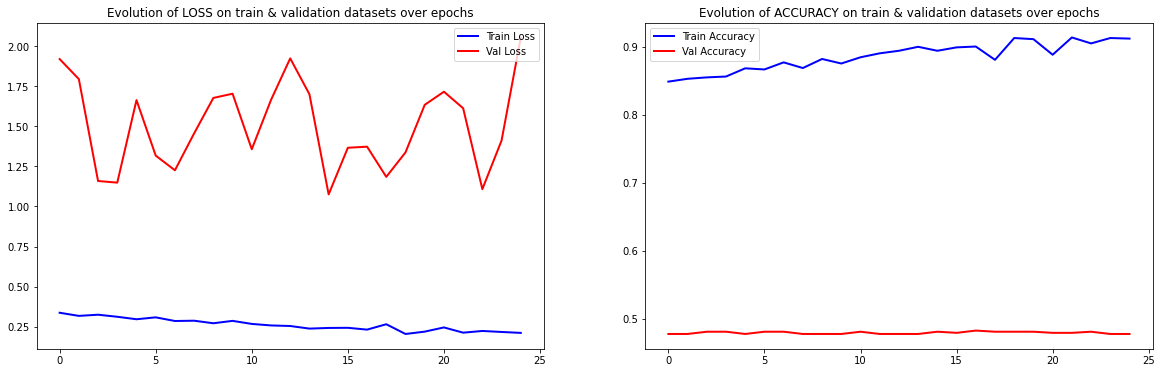

In [42]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_acc = history.history['accuracy']
epoch_val_acc = history.history['val_accuracy']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of LOSS on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2,label='Val Accuracy')
plt.title('Evolution of ACCURACY on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [43]:
loss, accuracy = resnet_model_fine_tuned.evaluate_generator(validation_generator, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation: accuracy = 0.477537  ;  loss = 2.053684 


In [44]:
predict = resnet_model_fine_tuned.predict_generator(test_generator)
threshold = 0.5
Y_test_pred = np.where(predict > 0.5, 1,0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [45]:
test_res = pd.read_csv('./predictions-test.csv')
Y_test_actual = test_res['label']
Y_test_actual = np.asarray(Y_test_actual)

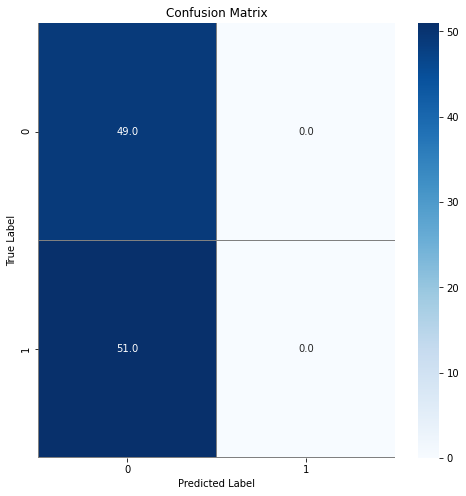

In [46]:
# compute the confusion matrix
Y_test_actual = Y_test_actual.astype('str')
Y_test_pred = Y_test_pred.astype('str')
# y_final = y_final.reshape
# print(type(Y_val), type(y_final), Y_val.shape, y_final.shape, len(Y_val_list[100]), len(Y_final_list))
confusion_mtx = confusion_matrix(Y_test_actual, Y_test_pred) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# RESNET50 fine tuning

In [8]:
from keras.applications import ResNet50

image_size = 224
input_shape = (image_size, image_size, 3)

resnet_pretrained_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

for layer in resnet_pretrained_model.layers[:140]:
    layer.trainable = False

for layer in resnet_pretrained_model.layers[140:]:
    layer.trainable = True

In [9]:
last_layer = resnet_pretrained_model.get_layer('conv5_block3_out')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 256 hidden units and ReLU activation
x = Dense(256, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

resnet_model_fine_tuned = Model(resnet_pretrained_model.input, x)

resnet_model_fine_tuned.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

resnet_model_fine_tuned.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [12]:
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = resnet_model_fine_tuned.fit_generator((train_generator), epochs=10,batch_size=2 
                              validation_data = (validation_generator), verbose=1)

C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 381s 754ms/step - loss: 2.5697 - accuracy: 0.2527 - val_loss: 1.6369 - val_accuracy: 0.4218
Epoch 2/10
500/500 [==============================] - 405s 809ms/step - loss: 1.8923 - accuracy: 0.3570 - val_loss: 1.5607 - val_accuracy: 0.4499
Epoch 3/10
500/500 [==============================] - 406s 812ms/step - loss: 1.7055 - accuracy: 0.4109 - val_loss: 1.7097 - val_accuracy: 0.4470
Epoch 4/10
500/500 [==============================] - 391s 783ms/step - loss: 1.5876 - accuracy: 0.4536 - val_loss: 1.4324 - val_accuracy: 0.5243
Epoch 5/10
500/500 [==============================] - 385s 769ms/step - loss: 1.4987 - accuracy: 0.4843 - val_loss: 1.3974 - val_accuracy: 0.5294
Epoch 6/10
500/500 [==============================] - 385s 770ms/step - loss: 1.4456 - accuracy: 0.5039 - val_loss: 1.3002 - val_accuracy: 0.5715
Epoch 7/10
500/500 [==============================] - 386s 772ms/step - loss: 1.3899 - accuracy: 0.5255 - val_loss: 1.3727 -

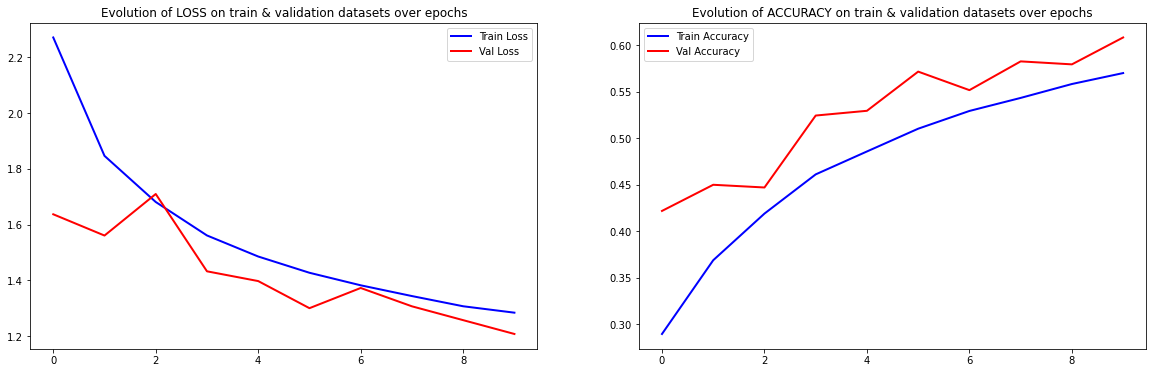

In [13]:
epoch_loss = hist.history['loss']
epoch_val_loss = hist.history['val_loss']
epoch_acc = hist.history['accuracy']
epoch_val_acc = hist.history['val_accuracy']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of LOSS on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2,label='Val Accuracy')
plt.title('Evolution of ACCURACY on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [20]:
loss, accuracy = model.evaluate_generator(validation_generator, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Validation: accuracy = 0.608200  ;  loss = 1.207700 


In [ ]:
predict = resnet_model_fine_tuned.predict_generator(test_generator)
threshold = 0.5
Y_test_pred = np.where(predict > 0.5, 1,0)

In [ ]:
test_res = pd.read_csv('./predictions-test.csv')
Y_test_actual = test_res['label']
Y_test_actual = np.asarray(Y_test_actual)

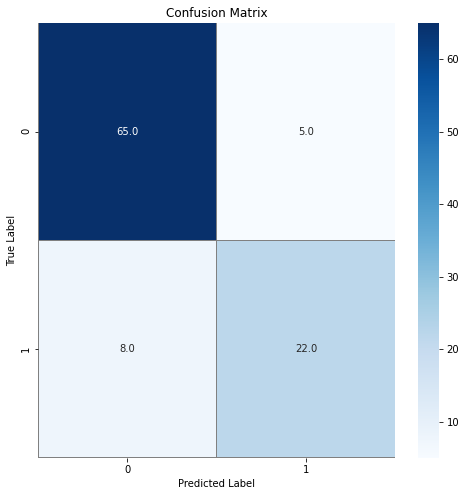

In [39]:
# compute the confusion matrix
Y_test_actual = Y_test_actual.astype('str')
Y_test_pred = Y_test_pred.astype('str')
# y_final = y_final.reshape
# print(type(Y_val), type(y_final), Y_val.shape, y_final.shape, len(Y_val_list[100]), len(Y_final_list))
confusion_mtx = confusion_matrix(Y_test_actual, Y_test_pred) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()